### import packages

In [1]:
from wespeaker.models.speaker_model import get_speaker_model
from wespeaker.utils.checkpoint import load_checkpoint
from wespeaker.utils.utils import parse_config_or_kwargs

from wespeaker.bin.score import trials_cosine_score, calculate_mean_from_kaldi_vec
from wespeaker.bin.compute_metrics import compute_metrics

from wespeaker.dataset.dataset import Dataset
from torch.utils.data import DataLoader
import copy

/home/yangwenhao/miniconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from scipy.io import wavfile
import torchaudio.compliance.kaldi as kaldi
import kaldiio
import torchaudio
import os
import numpy as np

import torch                     #1.12.1
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
data_dir = '/home/yangwenhao/project/SpeakerVerification-pytorch'
lstm_dir = '/home/yangwenhao/project/lstm_speaker_verification'

### load pretrained model

In [4]:
configs = parse_config_or_kwargs('model/voxceleb_resnet34_LM.yaml')
                                 
model = get_speaker_model(configs['model'])(**configs['model_args'])
load_checkpoint(model, 'model/voxceleb_resnet34_LM.pt')

In [5]:
device = 'cuda:0'
model = model.to(device)
model = model.eval()

### test dataset and dataloader

In [41]:
test_conf = copy.deepcopy(configs['dataset_args'])
test_conf['speed_perturb'] = False
if 'fbank_args' in test_conf:
    test_conf['fbank_args']['dither'] = 0.0
elif 'mfcc_args' in test_conf:
    test_conf['mfcc_args']['dither'] = 0.0
test_conf['spec_aug'] = False
test_conf['shuffle'] = False
test_conf['aug_prob'] = configs.get('aug_prob', 0.0)
test_conf['filter'] = False
batch_size = 32
num_workers = 6

dataset = Dataset('raw',
                  # 'data/vox1/test/raw.list', 
                  'data/vox2/dev/raw.list', #configs['data_list'],
                  test_conf,
                  spk2id_dict={},
                  whole_utt=(batch_size == 1),
                  # reverb_lmdb_file=configs.get('reverb_data', None),
                  # noise_lmdb_file=configs.get('noise_data', None),
                  reverb_lmdb_file=None,
                  noise_lmdb_file=None,
                  repeat_dataset=False)

dataloader = DataLoader(dataset,
                        shuffle=False,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        prefetch_factor=4)

### extract embeddings for vox1 test and vox2 dev

In [23]:
# embed_ark = 'data/vox1.test.ark'
# embed_scp = 'data/vox1.test.scp'

embed_ark = 'data/vox2.dev.ark'
embed_scp = 'data/vox2.dev.scp'

with torch.no_grad():
    with kaldiio.WriteHelper('ark,scp:' + embed_ark + "," +
                             embed_scp) as writer:
        for _, batch in tqdm(enumerate(dataloader), ncols=50):
            utts = batch['key']
            features = batch['feat']
            features = features.float().to(device)  # (B,T,F)
            
            # Forward through model
            outputs = model(features)  # embed or (embed_a, embed_b)
            embeds = outputs[-1] if isinstance(outputs, tuple) else outputs
            embeds = embeds.cpu().detach().numpy()  # (B,F)

            for i, utt in enumerate(utts):
                embed = embeds[i]
                writer(utt, embed)

34128it [46:28, 12.24it/s]


### mean vectors for vox2 dev

In [24]:
mean_vec = calculate_mean_from_kaldi_vec(embed_scp)

In [25]:
mean_vec_path = os.path.join('data', 'vox2_dev_mean_vec.npy')

In [26]:
np.save(mean_vec_path, mean_vec)

### score

In [27]:
trials_cosine_score('data/vox1.test.scp', 
                    'data',
                    mean_vec_path,
                    ('data/vox1/test/trials','trials.vox1_O_cleaned'))

scoring trial trials: 100%|█| 37720/37720 [00:07<0
scoring trial trials.vox1_O_cleaned: 100%|█| 37611


In [28]:
compute_metrics('data/trials.score')
compute_metrics('data/trials.vox1_O_cleaned.score')

# ---- trials.score -----
# EER = 2.211
# minDCF (p_target:0.01 c_miss:1 c_fa:1) = 0.162

# ---- trials.vox1_O_cleaned.score -----
# EER = 2.053
# minDCF (p_target:0.01 c_miss:1 c_fa:1) = 0.160

# ---- trials.score -----
# EER = 0.938
# minDCF (p_target:0.01 c_miss:1 c_fa:1) = 0.081
# ---- trials.vox1_O_cleaned.score -----
# EER = 0.797
# minDCF (p_target:0.01 c_miss:1 c_fa:1) = 0.078

---- trials.score -----
EER = 0.938
minDCF (p_target:0.01 c_miss:1 c_fa:1) = 0.081
---- trials.vox1_O_cleaned.score -----
EER = 0.797
minDCF (p_target:0.01 c_miss:1 c_fa:1) = 0.078


### Integrad

In [6]:
def padding_baselines(data, baselines):
    this_baselinses = []
    for the_data in baselines:
        while the_data.shape[-2] < data.shape[-2]:
            the_data = torch.cat([the_data, the_data], dim=0)
        
        the_data = the_data[:data.shape[-2]].float()
        this_baselinses.append(the_data)
        
    return torch.stack(this_baselinses).mean(dim=0)

In [7]:
def calculate_outputs_and_gradients(inputs, model,
                                    internal_batch=10):
    """sumary_line
    
    Keyword arguments:
    internal_batch -- internal batch_size has little effect on saliency mapplings.
    Return: return_description
    """
    
    # do the pre-processing
    gradients = []
    for s in inputs:
        s = Variable(s.cuda(), requires_grad=True)

        output = model(s)[-1]
        output = torch.nn.functional.cosine_similarity(output[0].unsqueeze(0), 
                                                       output[1].unsqueeze(0))
        # clear grad
        model.zero_grad()
        output.backward()

        gradient = s.grad.detach()#.cpu()
        gradients.append(gradient)
        
    gradients = torch.cat(gradients)

    return gradients

In [8]:
import json
from torch.autograd import Variable

In [9]:
num_mel_bins = 80
frame_length = 25
frame_shift = 10
sample_rate = 16000

In [10]:
select_dir = data_dir + '/Data/gradient/ThinResNet34/Mean_batch128_cbam_downk5_avg0_SAP2_em256_dp01_alpha0_none1_chn32_wde4_varesmix8/arcsoft_sgd_rop/vox2/wave_sp161_dist/123456/vox2_dev4'

data_reader = select_dir + '/data.h5py'
uid_reader   = select_dir + '/uid_idx.json'

assert os.path.exists(uid_reader)
with open(uid_reader, 'r') as f:
    uididx = json.load(f)
    
uid2path = {}
with open(lstm_dir + '/data/vox2/dev/wav.scp', 'r') as f:
    for l in f.readlines():
        uid, upath = l.split()
        uid2path[uid] = upath
        
baselines = []
for uid, idx in tqdm(uididx, ncols=50):
    upath = uid2path[uid]
    waveform_a, _ = torchaudio.load(upath)
    baselines.append(kaldi.fbank(waveform_a.float(), num_mel_bins=num_mel_bins,
                                  frame_length=frame_length, frame_shift=frame_shift,
                                  sample_frequency=sample_rate, window_type='hamming', use_energy=False))
    
baselines = [b-b.mean(dim=0, keepdim=True) for b in baselines]
baseline_lengths = [len(b) for b in baselines]

100%|██████| 23976/23976 [01:48<00:00, 221.00it/s]


In [11]:
uid2path = {}
with open(lstm_dir + '/data/vox1/test/wav.scp', 'r') as f:
    for l in f.readlines():
        uid, upath = l.split()
        uid2path[uid] = upath

In [12]:
steps = 50

  0%|                   | 0/37720 [00:00<?, ?it/s]

torch.Size([2, 90881])
torch.Size([2, 566, 80])
torch.Size([2, 566, 80])


  0%|                   | 0/37720 [00:19<?, ?it/s]


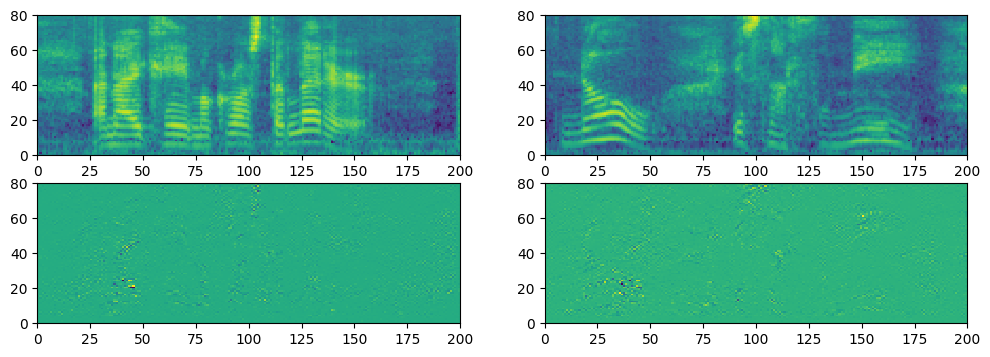

In [13]:
save_dir = 'model/resnet34_lm'
grad_file = save_dir + '/embeds.v1.test.h5py'

errors = []
with open(lstm_dir + '/data/vox1/test/trials', 'r') as f:
    for l in tqdm(f.readlines(), ncols=50):
        uid_a, uid_b, label = l.split()
        waveform_a, _ = torchaudio.load(uid2path[uid_a])
        waveform_b, _ = torchaudio.load(uid2path[uid_b])
        
        lengths = min(waveform_a.shape[1], waveform_b.shape[1])
        waveforms = torch.cat([waveform_a[:, :lengths],
                                         waveform_b[:, :lengths]], dim=0)
        print(waveforms.shape)
        mat = torch.stack([kaldi.fbank(w.unsqueeze(0).float().cuda(), num_mel_bins=num_mel_bins,
                                  frame_length=frame_length, frame_shift=frame_shift,
                                  sample_frequency=sample_rate, window_type='hamming', use_energy=False) for w in waveforms])
        print(mat.shape)
        
        mat = mat - mat.mean(dim=1, keepdim=True)

        the_data = mat
        # baseline = 0. * the_data
        baseline = padding_baselines(the_data, baselines)
        baseline = torch.stack([baseline, baseline])
        
        print(baseline.shape)
        # break
        baseline = baseline.cuda()
        scaled_inputs = [baseline + (float(i) / steps) * (the_data - baseline) for i in
                        range(1, steps + 1)]

        the_grads = calculate_outputs_and_gradients(
            scaled_inputs, model)

        the_grads = the_grads[:-1]

        avg_grads = the_grads.mean(dim=0)
        in_grad = (the_data - baseline) * avg_grads  # shape: <grad.shape>
        
        plt.figure(figsize=(12, 4))
        plt.subplot(2,2,1)
        plt.pcolormesh(mat[0].detach().cpu().numpy()[:200].T)
        
        plt.subplot(2,2,2)
        plt.pcolormesh(mat[1].detach().cpu().numpy()[:200].T)
        
        plt.subplot(2,2,3)
        plt.pcolormesh(in_grad[0].detach().cpu().numpy()[:200].T)
        
        plt.subplot(2,2,4)
        plt.pcolormesh(in_grad[1].detach().cpu().numpy()[:200].T)
        
        break

In [24]:
grad_a = in_grad[0]
grad_b = in_grad[1]

In [25]:
norm_grad_a = (grad_a - grad_a.min()) / (grad_a.max() - grad_a.min())
norm_grad_b = (grad_b - grad_b.min()) / (grad_b.max() - grad_b.min())

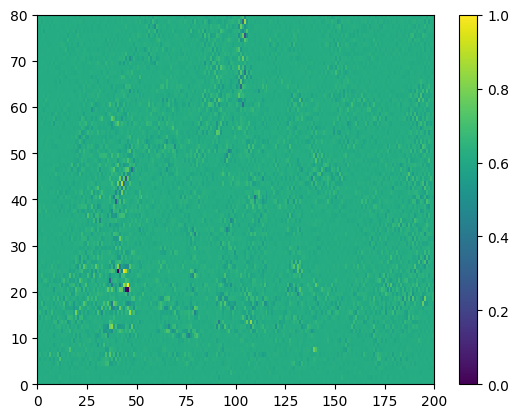

In [27]:
plt.pcolormesh(norm_grad_a.detach().cpu().numpy()[:200].T)
plt.colorbar()

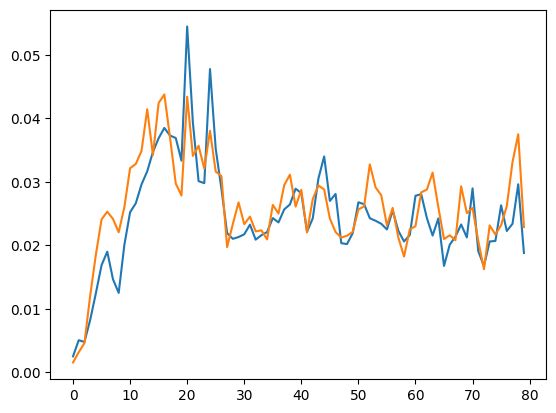

In [28]:
plt.plot(norm_grad_a.std(dim=0).detach().cpu())
plt.plot(norm_grad_b.std(dim=0).detach().cpu())